In [153]:
%matplotlib inline
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
import matplotlib.pyplot as plt
# import collections
from sklearn.model_selection import train_test_split
# import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, roc_auc_score


In [117]:
PATH = 'data/Readmissions/'
train_orig = pd.read_csv(f'{PATH}diabetic_data.csv')

In [118]:
train_orig.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,flag_1,flag_2
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.460881,0.810163
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.498470,0.923239
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000,2.000000


### Cleaning up the dataset

In [119]:
train_orig = train_orig.replace('?', np.nan)
print(train_orig.count() / len(train_orig.index))
#items with more than 90% missing data!
print(' **** Columns with more that 90\% missing data ***')
print(train_orig.columns[(train_orig.count() / len(train_orig.index))<0.9])
# df = df.dropna(axis='rows')

encounter_id                1.000000
patient_nbr                 1.000000
race                        0.977664
gender                      1.000000
age                         1.000000
weight                      0.031415
admission_type_id           1.000000
discharge_disposition_id    1.000000
admission_source_id         1.000000
time_in_hospital            1.000000
payer_code                  0.604426
medical_specialty           0.509178
num_lab_procedures          1.000000
num_procedures              1.000000
num_medications             1.000000
number_outpatient           1.000000
number_emergency            1.000000
number_inpatient            1.000000
diag_1                      0.999794
diag_2                      0.996482
diag_3                      0.986017
number_diagnoses            1.000000
max_glu_serum               1.000000
A1Cresult                   1.000000
metformin                   1.000000
repaglinide                 1.000000
nateglinide                 1.000000
c

In [120]:
len(train_orig)

101766

In [121]:
# dropping columns with more than 90% missing data
df = train_orig.dropna(thresh=0.9*len(train_orig.index),axis='columns')
#dropping any patients with missing data in any column
df = df.dropna(axis='rows')
df = df.drop(['encounter_id','patient_nbr', 'readmitted'],axis=1)
# print(df.count() / len(df.index))
# df.shape

In [122]:
len(df)

98053

In [123]:
level1_edges = pd.read_csv(f'{PATH}level1_bins.csv', header=None)
level1_edges = list(level1_edges.values.flatten())

level2_edges = pd.read_csv(f'{PATH}level2_bins.csv', header=None)
level2_edges = list(level2_edges.values.flatten())

In [126]:
for tt in ["diag_1", "diag_2", "diag_3"]:
    t = tt + "_short"
    df[t] = df[tt]
    df[t][df[t].str.startswith('V', na=False)] = '1200'
    df[t][df[t].str.startswith('E', na=False)] = '1200'
    df[t] = df[t].astype('float')
    df[t] = pd.np.digitize(df[t], bins=level1_edges)
    
    t = tt + "_long"
    df[t] = df[tt]
    df[t][df[t].str.startswith('V', na=False)] = '1200'
    df[t][df[t].str.startswith('E', na=False)] = '1200'
    df[t] = df[t].astype('float')
    df[t] = pd.np.digitize(df[t], bins=level2_edges)
df = df.drop(['diag_1','diag_2', 'diag_3'],axis=1)
# to_drop_meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
# df = df.drop(to_drop_meds,axis=1)

In [127]:
to_drop_meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

df_meds = df[to_drop_meds]
for t in df_meds:
    df_meds[t][df_meds[t]=='No']= 0
    df_meds[t][df_meds[t]=='Down']= 1
    df_meds[t][df_meds[t]=='Steady']= 1
    df_meds[t][df_meds[t]=='Up']= 1
count_meds = (df_meds > 0).sum(axis=1)
df['diabetes_med_counts'] = count_meds

In [128]:
df = df.drop(to_drop_meds,axis=1)

### Identifying numerical and categorical features

In [129]:
numerical_features = list(df.columns[df.dtypes=='int64'])
text_features = list(df.columns[df.dtypes=='object'])

# text_features
categorical_features = text_features + list(['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'flag_1', 'flag_2', 'diag_1_short',
                                            'diag_2_short', 'diag_3_short', 'diag_1_long', 'diag_2_long', 'diag_3_long'])
continuous_features = [e for e in numerical_features if e not in list(['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'flag_1', 'flag_2', 'diag_1_short',
                                            'diag_2_short', 'diag_3_short', 'diag_1_long', 'diag_2_long', 'diag_3_long'])]


In [130]:
for v in categorical_features: df[v] = df[v].astype('category').cat.as_ordered()
for v in continuous_features: df[v] = df[v].astype('float')
for v in ['flag_1','flag_2']: df[v] = df[v].astype('int')
df['flag'] = df['flag_1']==1
df['flag'].value_counts()

df = df[categorical_features+continuous_features].copy()
categorical_features.remove('flag_1')
categorical_features.remove('flag_2')

print('Categorical Features : \n ', categorical_features)
print('Continuous Features : \n ',continuous_features)

Categorical Features : 
  ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1_short', 'diag_2_short', 'diag_3_short', 'diag_1_long', 'diag_2_long', 'diag_3_long']
Continuous Features : 
  ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diabetes_med_counts']


In [133]:
df['flag'] = df['flag_2']==1
df['flag'].value_counts()

False    86987
True     11066
Name: flag, dtype: int64

In [15]:
df.to_csv(f'{PATH}cleaned_diabetic_data.csv')

In [135]:
df_fin, y, nas, mapper = proc_df(df, 'flag', skip_flds = ['flag_1','flag_2'],do_scale=True)
# df_fin.dtypes

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(df_fin, y, test_size = 0.20)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=1)

In [137]:
n = len(X_train); n
idxs = get_cv_idxs(n, val_pct=10000/n)

### Defining Entity Embeddings for categorical variables

In [138]:
cat_sz = [(c, len(df[c].cat.categories)) for c in categorical_features]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
# (emb_szs)


[('race', 5), ('gender', 3), ('age', 10), ('max_glu_serum', 4), ('A1Cresult', 4), ('change', 2), ('diabetesMed', 2), ('admission_type_id', 8), ('discharge_disposition_id', 26), ('admission_source_id', 17), ('diag_1_short', 17), ('diag_2_short', 17), ('diag_3_short', 17), ('diag_1_long', 105), ('diag_2_long', 104), ('diag_3_long', 104)]


In [140]:
md = ColumnarModelData.from_data_frame(PATH, idxs, X_train, Y_train.astype(np.long), cat_flds=categorical_features, bs=128,  test_df= X_test,is_reg=False)
m = md.get_learner(emb_szs, len(df_fin.columns) - len(categorical_features), 0.04, 2, [1000,500], [0.01,0.01],crit=F.cross_entropy)
# m.summary()

 65%|████████████████████████████████████████████▊                        | 347/535 [00:05<00:02, 63.98it/s, loss=1.42]


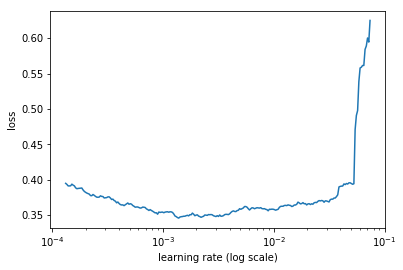

 65%|████████████████████████████████████████████▊                        | 347/535 [00:20<00:02, 63.98it/s, loss=1.42]

In [141]:
lr = 1e-3
m.lr_find()
m.sched.plot(100)

In [71]:
# m.sched.plot_lr()

In [142]:
lr=0.0055
m.fit(lr, 10, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.344833   0.337464   0.887     
    1      0.336631   0.344346   0.8868                                                                                
    2      0.3285     0.338054   0.8866                                                                                
    3      0.327707   0.335971   0.8863                                                                                
    4      0.322434   0.339307   0.8864                                                                                
    5      0.326258   0.343339   0.8861                                                                                
    6      0.330892   0.350499   0.8853                                                                                
    7      0.324176   0.342482   0.8859                                                                             

[array([0.36937]), 0.8845]

### 3 Class Classification 

In [160]:
df.pivot_table(index='flag_2',aggfunc=len)

,A1Cresult,admission_source_id,admission_type_id,age,change,diabetesMed,diabetes_med_counts,diag_1_long,diag_1_short,diag_2_long,...,max_glu_serum,num_lab_procedures,num_medications,num_procedures,number_diagnoses,number_emergency,number_inpatient,number_outpatient,race,time_in_hospital
flag_2,,,,,,,,,,,,,,,,,,,,,
0,52338,52338,52338,52338,52338,52338,52338.0,52338,52338,52338,...,52338,52338.0,52338.0,52338.0,52338.0,52338.0,52338.0,52338.0,52338,52338.0
1,11066,11066,11066,11066,11066,11066,11066.0,11066,11066,11066,...,11066,11066.0,11066.0,11066.0,11066.0,11066.0,11066.0,11066.0,11066,11066.0
2,34649,34649,34649,34649,34649,34649,34649.0,34649,34649,34649,...,34649,34649.0,34649.0,34649.0,34649.0,34649.0,34649.0,34649.0,34649,34649.0


In [147]:
df_fin, y, nas, mapper= proc_df(df, 'flag_2', skip_flds = ['flag','flag_1'],do_scale=True)
X_train, X_test, Y_train, Y_test = train_test_split(df_fin, y, test_size = 0.1,stratify=y)
n = len(X_train); n
idxs = get_cv_idxs(n, val_pct=10000/n)

 84%|██████████████████████████████████████████████████████████▎          | 517/612 [00:06<00:01, 85.73it/s, loss=4.07]


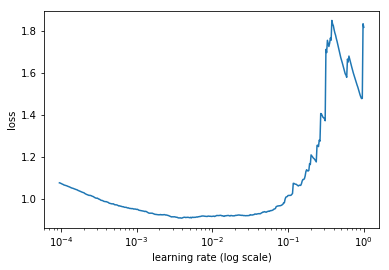

 84%|██████████████████████████████████████████████████████████▎          | 517/612 [00:24<00:01, 85.73it/s, loss=4.07]

In [150]:
md_2 = ColumnarModelData.from_data_frame(PATH, idxs, X_train, Y_train.astype(np.long), cat_flds=categorical_features, bs=128,  test_df= X_test,is_reg=False)
m2 = md_2.get_learner(emb_szs, len(df_fin.columns) - len(categorical_features), 0.00, 3, [500], [0.01],crit=F.cross_entropy)
# m.summary()

lr = 1e-3
m2.lr_find()
m2.sched.plot(100)

In [151]:
m2.fit(10e-3, 5, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.887302   0.882809   0.578     
    1      0.880766   0.878713   0.5823                                                                                
    2      0.881985   0.884441   0.5759                                                                                
    3      0.880971   0.882139   0.5778                                                                                
    4      0.883573   0.879257   0.58                                                                                  



[array([0.87926]), 0.58]

In [152]:
m2.fit(10e-3, 10, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.871082   0.885699   0.5788    
    1      0.874341   0.875889   0.5817                                                                                
    2      0.869032   0.880668   0.5807                                                                                
    3      0.880301   0.889445   0.5784                                                                                
    4      0.877453   0.882828   0.5749                                                                                
    5      0.883208   0.879441   0.5778                                                                                
    6      0.866976   0.88996    0.5761                                                                                
    7      0.87016    0.883467   0.5747                                                                             

[array([0.88887]), 0.5705]

AUC: %d [0.6894  0.6762  0.64338]


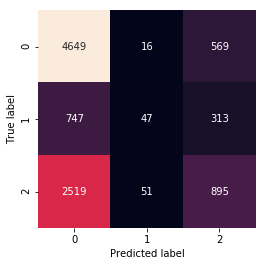

In [154]:
preds = m2.predict(True)
ypreds = preds.argmax(axis=1)

from sklearn.metrics import confusion_matrix, roc_auc_score

mat = confusion_matrix(Y_test, ypreds)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Get one hot encoding to compute AUC value
enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
out_val = enc.fit(Y_test.reshape(-1, 1))
out_val = enc.transform(Y_test.reshape(-1, 1))
print("AUC: %d", roc_auc_score(out_val,preds,average=None))